# Knowledge-exploration
## Topics based analysis

In [3]:
import torch

# Check if the GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

True

In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP

## Dataset and embedding
* data: question 1,2,3,4,5
* word-embedding: distilbert

## Question 1

### Dimensionality reduction: UMAP

In [5]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/knowledge_distilbert_answer1.jsonl", orient = 'index')

In [6]:
emb

,participant_id,answer1,embedding1
0,00278,vaccination scheme area,"[-0.1912737638, -0.1773329824, -0.2605425715, ..."
1,00278,increase awareness education,"[-0.0679296777, -0.13514108960000001, -0.13267..."
2,00278,mass vaccination programme,"[-0.1031195149, -0.2114465237, -0.3880674839, ..."
3,00278,gp practice discus patient,"[-0.2258333266, -0.0020551765, -0.049876611700..."
4,00278,advertisement vaccination need availability,"[-0.12228399520000001, 0.0300362222, -0.148336..."
...,...,...,...
1289,fb9c4,visiting local school vaccinating child,"[-0.21164929870000002, -0.1067790091, -0.25087..."
1290,fb9c4,offering door door vaccination programme,"[-0.1927827597, -0.1603478342, -0.1013129428, ..."
1291,ff2bf,education benefit vaccination,"[-0.046285025800000004, -0.1358169317, -0.3770..."
1292,ff2bf,reward incentive eg cash good,"[-0.3334721625, -0.1730621904, 0.0921666175, 0..."


In [7]:
# "transform embedding"
from ast import literal_eval
emb['embedding1'] = emb['embedding1'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding1'].values)
matrix.shape

(1294, 768)

In [8]:
X = matrix.copy()

In [9]:
X.shape

(1294, 768)

In [10]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [11]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

### silhouette score

In [12]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [13]:
optimal_num_clusters

3

### elbow method

In [14]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

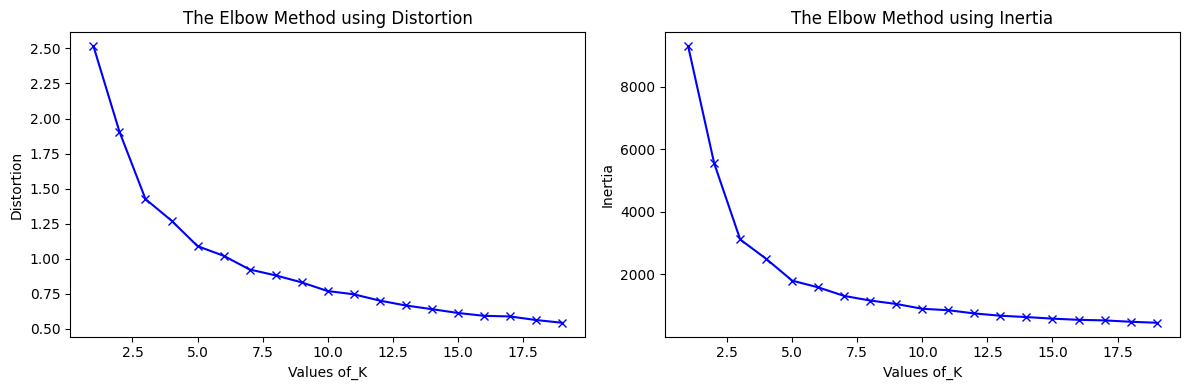

In [15]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [16]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 3, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['label'] = final_cluster_labels  

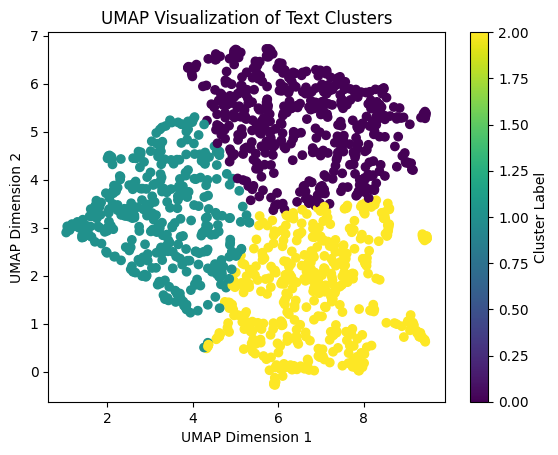

In [17]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [18]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 1\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 1"

Silhouette Coefficient: 0.4316019117832184
Calinski-Harabasz Index: 1282.9707359404847
Davies-Bouldin Index: 0.790574967757269


## Manual check

In [19]:
emb

,participant_id,answer1,embedding1,label
0,00278,vaccination scheme area,"[-0.1912737638, -0.1773329824, -0.2605425715, ...",1
1,00278,increase awareness education,"[-0.0679296777, -0.13514108960000001, -0.13267...",0
2,00278,mass vaccination programme,"[-0.1031195149, -0.2114465237, -0.3880674839, ...",0
3,00278,gp practice discus patient,"[-0.2258333266, -0.0020551765, -0.049876611700...",2
4,00278,advertisement vaccination need availability,"[-0.12228399520000001, 0.0300362222, -0.148336...",0
...,...,...,...,...
1289,fb9c4,visiting local school vaccinating child,"[-0.21164929870000002, -0.1067790091, -0.25087...",1
1290,fb9c4,offering door door vaccination programme,"[-0.1927827597, -0.1603478342, -0.1013129428, ...",1
1291,ff2bf,education benefit vaccination,"[-0.046285025800000004, -0.1358169317, -0.3770...",0
1292,ff2bf,reward incentive eg cash good,"[-0.3334721625, -0.1730621904, 0.0921666175, 0...",2


In [20]:
# create the community of the case ids(respondents) that are the result of the clustering
keys = ['one', 'zero', 'two']
communities = {key: [] for key in keys}

emb['id_case'] = emb.index

for i in range(len(emb)):
    if emb['label'].iloc[i] == 1:
        communities['one'].append(emb['id_case'].iloc[i])
    elif emb['label'].iloc[i] == 0: 
        communities['zero'].append(emb['id_case'].iloc[i])
    elif emb['label'].iloc[i] == 2: 
        communities['two'].append(emb['id_case'].iloc[i])

## Question1 clusters contents

In [21]:
q1_answers = {}

# Loop through each community in the 'communities' dictionary
for key, index_list in communities.items():
    # Initialize a list to store the answers for the current community
    q1_answers[key] = []
    
    # Loop through the indices and append the corresponding values from 'emb'
    for index in index_list:
        q1_answers[key].append(emb['answer1'].iloc[index])

In [22]:
emb['answer1'].iloc[0]

'vaccination scheme area'

In [23]:
q1_answers['zero']

['increase awareness education',
 'mass vaccination programme',
 'advertisement vaccination need availability',
 'ask various clerical leader pas message congregation',
 'get rural gp advocate vaccination',
 'pr benefit vaccine',
 'offer reward vaccination',
 'run clinic make people aware risk',
 'better advertising',
 'le negative talk vaccination',
 'try explain vaccine work',
 'stop using aggressive campaign wont generally work',
 'motivate giving thems something maybe',
 'encourage relativesfriends tell benefit vaccine',
 'improved communication includes face face discussion',
 'make obligatory pandemic situation',
 'general access made easier',
 'educate people',
 'go doortodoor vaccinate',
 'engage local community group facilitate',
 'promote benefit vaccinated via leaflet',
 'address negative belief vaccination',
 'make vaccine material accessible',
 'posting flyer every household',
 'encourage risk category healthcare setting eg drs surgery',
 'promote benefit vaccine',
 'mobil

In [24]:
q1_answers['one']

['vaccination scheme area',
 'mobile vaccination van used',
 'get people vaccination travel rural area',
 'visiting nurse',
 'dropin rural clinic',
 'ensure people rural area easy access vaccination centre',
 'take vaccination rural area',
 'mobile vaccination unit',
 'put vaccination building area',
 'make accessible rural area',
 'cake tea etc included',
 'bring mobile vac unit',
 'mobile vac unit',
 'provide mobile clinic',
 'pay people vaccinated',
 'put vaccination centre supermarket',
 'offer door door service people unable leave home',
 'taking mini bus round',
 'laying taxi',
 'recruit nurse area',
 'create vaccination campaign area',
 'recruit support staff assist exercise',
 'employ medical staff',
 'vaccination hub pub etc',
 'district nurse',
 'outsourcing private healthcare',
 'mobile vaccination ie go home',
 'vaccination community centre church',
 'mobile vaccine clinic like mobile library',
 'provide vaccination centre',
 'use trained staff visit area vaccination day',


In [25]:
q1_answers['two']

['gp practice discus patient',
 'introduce topic school',
 'advertise local shop',
 'use advert local paper',
 'putting money trust til 18',
 'free transport le rural area',
 'evening visit',
 'leaflet every home',
 'use gp surgery',
 'organise targeted campaign rural area',
 'engage spokesperson would relatable people rural area',
 'televise targeted ad',
 'inquiry dont get vaccinated',
 'drop clinic',
 'leafet drop',
 'voucher shopping',
 'bother',
 'think low',
 'send reminder people get',
 'make sure know help',
 'educating people usually dont opportunity someone big city',
 'programme education tv advantage',
 'advertise vac unit would come',
 'ask doc call patient',
 'certain day could come',
 'advertising campaign',
 'provide home visit',
 'use',
 'advertise benefit vaccination',
 'make compulsory',
 'set local vaccination area convenient go',
 'offer sort incentive voucher prize',
 'make people fully aware risk putting dont',
 'vaccinating local pub',
 'clinic local shop',
 're

## Question 2

### Dimensionality reduction: UMAP

In [26]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/knowledge_distilbert_answer2.jsonl", orient = 'index')

In [27]:
emb

,participant_id,answer2,embedding2
0,00278,equal pay woman men role,"[-0.2724666297, -0.11421003190000001, -0.25762..."
1,00278,ensure woman voice heard,"[-0.2066235542, -0.0577824451, -0.0253684297, ..."
2,00278,woman equally considered promotion,"[-0.3257834613, -0.0590515062, -0.1927293688, ..."
3,00278,education sexual harassment,"[-0.151885882, 0.0303863995, -0.38983130460000..."
4,00278,woman seen equal men capable,"[-0.2573717535, -0.19600646200000002, -0.17586..."
...,...,...,...
1294,fb9c4,female high paying role within company,"[-0.335631758, -0.17630937700000002, -0.230590..."
1295,fb9c4,offering male female worker time maternitypate...,"[-0.330673486, -0.048639964300000005, -0.20348..."
1296,ff2bf,gender identity workshop staff,"[-0.29391214250000003, -0.0150234727, -0.37965..."
1297,ff2bf,look current procedure improved,"[-0.24768836800000002, -0.2251698077, 0.009284..."


In [28]:
# "transform embedding"
from ast import literal_eval
emb['embedding2'] = emb['embedding2'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding2'].values)
matrix.shape

(1299, 768)

In [29]:
X = matrix.copy()

In [30]:
X.shape

(1299, 768)

In [31]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [32]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

### silhouette score

In [33]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [34]:
optimal_num_clusters

2

### elbow method

In [35]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

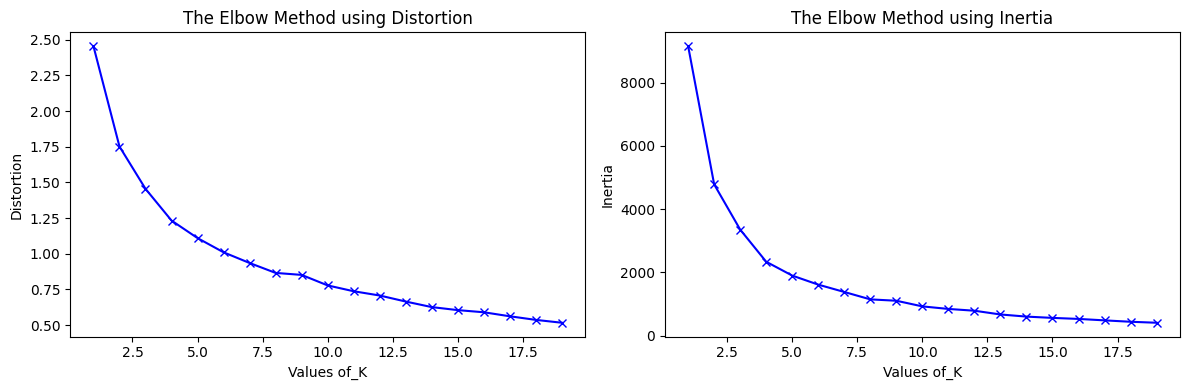

In [36]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [37]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 2, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

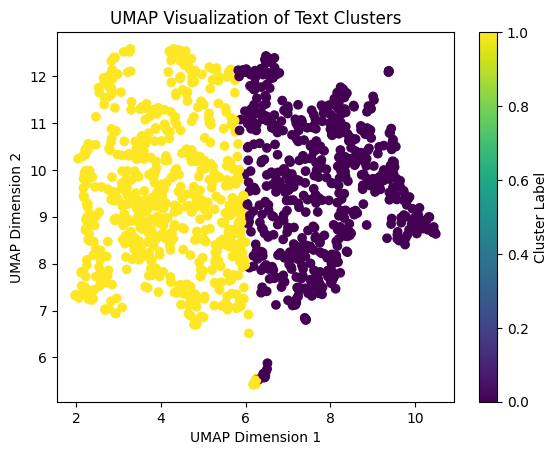

In [38]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [39]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 2\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 2"

Silhouette Coefficient: 0.410663902759552
Calinski-Harabasz Index: 1178.384255275074
Davies-Bouldin Index: 0.9534389364578983


## Question 3

### Dimensionality reduction: UMAP

In [40]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/knowledge_distilbert_answer3.jsonl", orient = 'index')

In [41]:
emb

,participant_id,answer3,embedding3
0,00278,look conservation plan,"[-0.2600734234, -0.102480948, -0.0680152327, -..."
1,00278,ensure poacher prosecuted stopped,"[-0.1930021346, -0.09409610930000001, -0.13883..."
2,00278,protect land live,"[0.0290395655, -0.1506019831, -0.2147008181, -..."
3,00278,protected area people access,"[-0.2305000275, 0.1180906594, -0.2513935268, -..."
4,00278,stop used human entertainmenttourism,"[-0.0794864222, -0.0770247951, -0.083366744200..."
...,...,...,...
1325,fb9c4,prosecute profit elephant called sancturies,"[-0.14983583990000002, 0.0153998993, -0.383470..."
1326,fb9c4,create scheme impregnate lot female elephant,"[-0.2940057814, -0.2693106532, -0.2215505689, ..."
1327,ff2bf,ban ivory importsexports,"[-0.1749877334, 0.026809141, -0.1870026886, -0..."
1328,ff2bf,try breed captivity,"[-0.0904416442, -0.1912278533, -0.1173987985, ..."


In [42]:
# "transform embedding"
from ast import literal_eval
emb['embedding3'] = emb['embedding3'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding3'].values)
matrix.shape

(1330, 768)

In [43]:
X = matrix.copy()

In [44]:
X.shape

(1330, 768)

In [45]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [46]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

### silhouette score

In [47]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [48]:
optimal_num_clusters

2

### elbow method

In [49]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

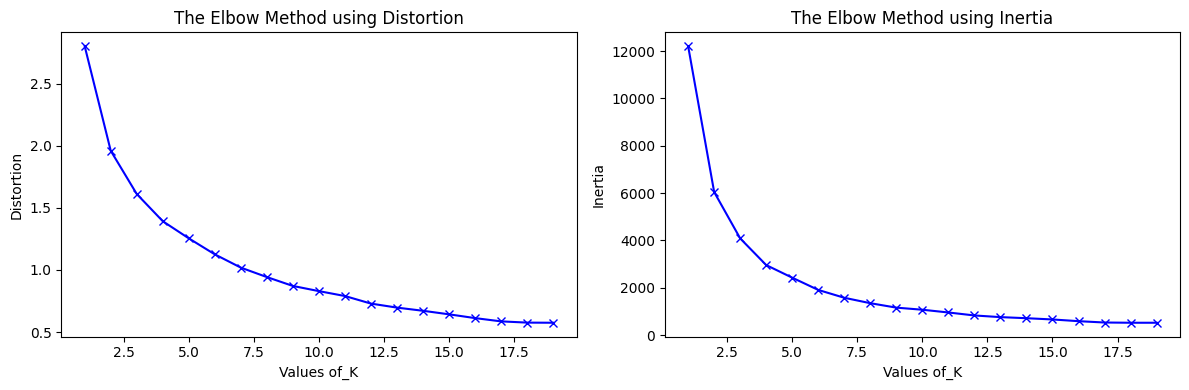

In [50]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [51]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 4, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

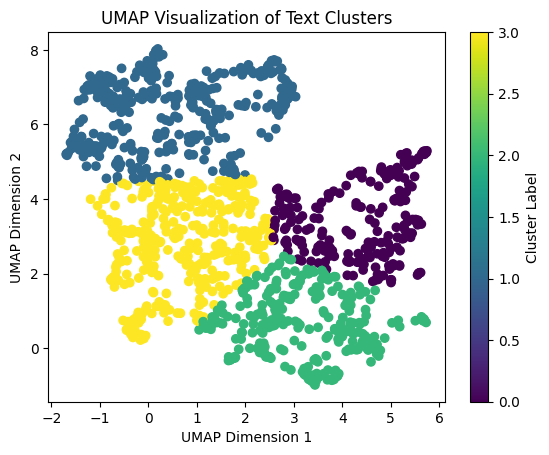

In [52]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [53]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 3\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 3"

Silhouette Coefficient: 0.40014833211898804
Calinski-Harabasz Index: 1381.3020038538132
Davies-Bouldin Index: 0.8318901224422474


### Question 4
"How could we increase the use of public transport?"

### Dimensionality reduction: UMAP

In [54]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/knowledge_distilbert_answer4.jsonl", orient = 'index')

In [55]:
emb

,participant_id,answer4,embedding4
0,00278,make affordable,"[-0.1105325967, -0.1894581169, -0.0378764495, ..."
1,00278,make reliable,"[-0.13820765910000002, -0.0330862291, 0.051397..."
2,00278,make accessible,"[-0.19806034860000002, -0.1453855783, -0.02777..."
3,00278,hire staff support service,"[-0.0248319954, -0.0327678062, -0.1984655261, ..."
4,00278,funding newfaster route,"[-0.23124073450000002, -0.12966595590000002, -..."
...,...,...,...
1223,fb9c4,reward scheme often use public transport,"[-0.1002430916, -0.0190638453, -0.0021208241, ..."
1224,fb9c4,increase hygiene level bus train,"[-0.0652128682, -0.2534413636, -0.1337117553, ..."
1225,ff2bf,free travel need,"[-0.0975238457, 0.0551965944, -0.0085168928, 0..."
1226,ff2bf,le parking private vehicle,"[-0.2252171785, -0.0977024063, -0.1309071779, ..."


In [56]:
# "transform embedding"
from ast import literal_eval
emb['embedding4'] = emb['embedding4'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding4'].values)
matrix.shape

(1228, 768)

In [57]:
X = matrix.copy()

In [58]:
X.shape

(1228, 768)

In [59]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [60]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

### silhouette score

In [61]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [62]:
optimal_num_clusters

3

### elbow method

In [63]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

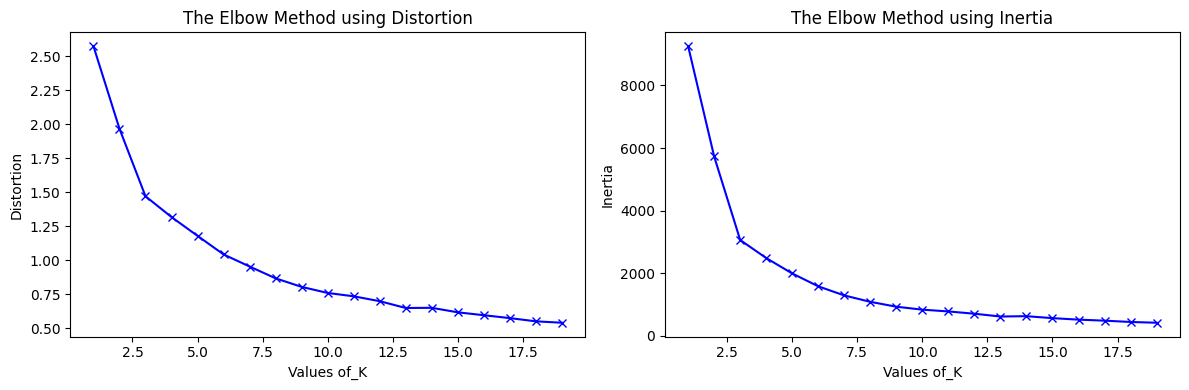

In [64]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [65]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 3, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

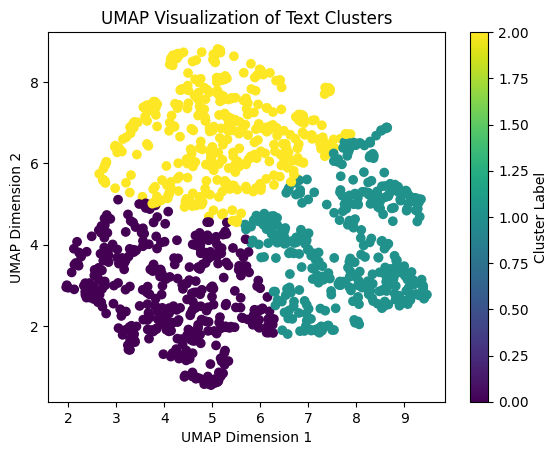

In [66]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [67]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 4\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 4"

Silhouette Coefficient: 0.43442198634147644
Calinski-Harabasz Index: 1240.0281670630034
Davies-Bouldin Index: 0.784404178784


### Question 5
"How could we reduce stress in our society?"

### Dimensionality reduction: UMAP

In [68]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/knowledge_distilbert_answer5.jsonl", orient = 'index')

In [69]:
emb

,participant_id,answer5,embedding5
0,00278,better worklife balance,"[-0.1815529615, 0.010370405400000001, -0.05033..."
1,00278,flexible working,"[-0.251532644, -0.1444953233, -0.0904041007, -..."
2,00278,affordable bill housing,"[-0.21748660500000003, -0.2282460332, -0.14886..."
3,00278,higher living wage,"[-0.1493705064, -0.0670947954, -0.127010494500..."
4,00278,accessible healthcare,"[-0.1880748421, -0.08514208350000001, -0.10695..."
...,...,...,...
1306,fb9c4,creative style based curriculum school,"[-0.1106137261, -0.0771657079, -0.221054777500..."
1307,fb9c4,advocate importance mental health school workp...,"[-0.105100438, 0.0275602192, -0.2021109164, -0..."
1308,ff2bf,kinder,"[-0.37797144060000004, -0.1559488922, -0.02280..."
1309,ff2bf,educate people mental health issue,"[0.0021075674, -0.1419937462, -0.4769175649000..."


In [70]:
# "transform embedding"
from ast import literal_eval
emb['embedding5'] = emb['embedding5'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding5'].values)
matrix.shape

(1311, 768)

In [71]:
X = matrix.copy()

In [72]:
X.shape

(1311, 768)

In [73]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [74]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

### silhouette score

In [75]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [76]:
optimal_num_clusters

2

### elbow method

In [77]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

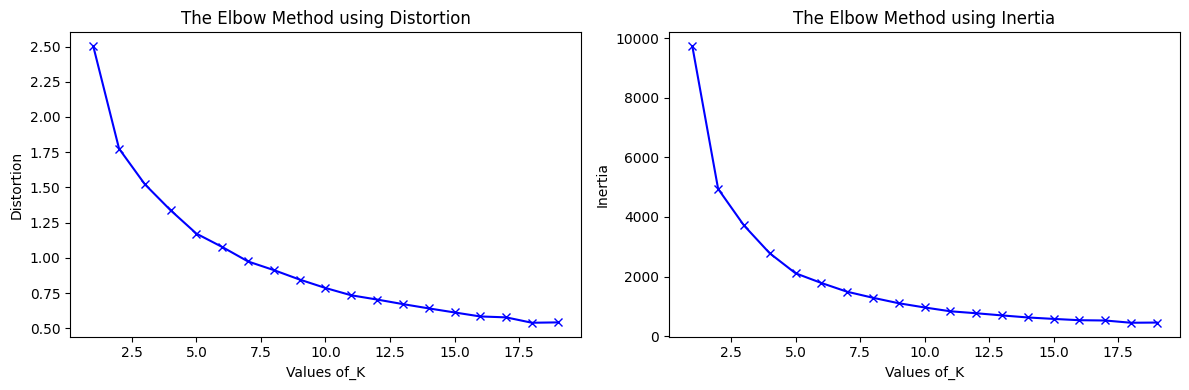

In [78]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [79]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 2, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

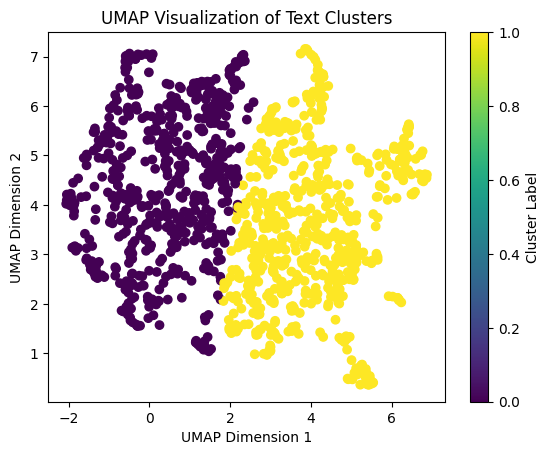

In [80]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [81]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 5\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 5"

Silhouette Coefficient: 0.4230940639972687
Calinski-Harabasz Index: 1266.7470804685638
Davies-Bouldin Index: 0.9284104516759695


In [ ]:
0.